In [ ]:
!pip install torch torchvision datasets scikit-learn matplotlib seaborn --upgrade


In [ ]:
from datasets import load_dataset

# This will download and cache the MNIST dataset from the Hugging Face hub
mnist = load_dataset("ylecun/mnist")


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def preprocess(example):
    image = transform(example["image"])
    return {"image": image.view(-1)}

mnist = mnist.map(preprocess)

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from torchvision import transforms

# Convert PIL images to tensor and flatten
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 -> 784
])

train_data = torch.stack([transform(example['image']) for example in mnist['train']])
dataset = TensorDataset(train_data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define your Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    for batch in dataloader:
        imgs = batch[0].to(device)
        encoded, decoded = model(imgs)
        loss = criterion(decoded, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.9239
Epoch 2, Loss: 0.9244
Epoch 3, Loss: 0.9238
Epoch 4, Loss: 0.9278
Epoch 5, Loss: 0.9236
Epoch 6, Loss: 0.9247
Epoch 7, Loss: 0.9250
Epoch 8, Loss: 0.9233
Epoch 9, Loss: 0.9256
Epoch 10, Loss: 0.9278


In [ ]:
model.eval()
with torch.no_grad():
    embeddings = model.encoder(train_data.to(device)).cpu()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

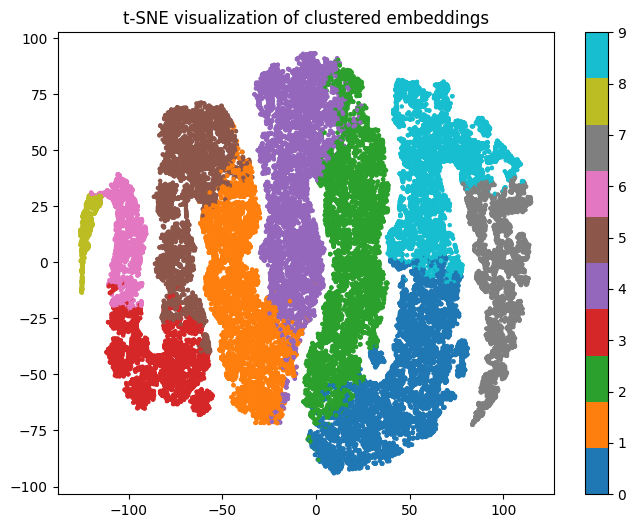

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab10', s=5)
plt.title("t-SNE visualization of clustered embeddings")
plt.colorbar()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(embeddings, cluster_labels)
db_index = davies_bouldin_score(embeddings, cluster_labels)
ch_index = calinski_harabasz_score(embeddings, cluster_labels)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

Silhouette Score: 0.4298
Davies-Bouldin Index: 0.6389
Calinski-Harabasz Index: 250998.6094


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
import random
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=32):
        super().__init__()
        # encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_dec1(z))
        return torch.sigmoid(self.fc_dec2(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z

def vae_loss(recon_x, x, mu, logvar, recon_weight=1.0, kl_weight=1.0):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_weight * recon_loss + kl_weight * kl) / x.shape[0]


Device: cpu


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_vae(model, train_loader, val_loader=None, epochs=20, lr=1e-3, kl_weight=1.0, save_path=None):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': []}
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb, in train_loader:
            xb = xb.to(device)
            opt.zero_grad()
            recon, mu, logvar, z = model(xb)
            loss = vae_loss(recon, xb, mu, logvar, recon_weight=1.0, kl_weight=kl_weight)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)
        print(f'Epoch {epoch}/{epochs}  Train Loss: {avg_loss:.4f}')
    if save_path:
        torch.save(model.state_dict(), save_path)
    return history


In [ ]:
def get_embeddings(model, data_loader):
    model.eval()
    zs = []
    ys = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            recon, mu, logvar, z = model(xb)
            zs.append(mu.cpu().numpy())
            ys.append(yb.numpy())
    zs = np.vstack(zs)
    ys = np.concatenate(ys)
    return zs, ys

def clustering_metrics(embeddings, labels, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    preds = kmeans.fit_predict(embeddings)
    ari = adjusted_rand_score(labels, preds)
    nmi = normalized_mutual_info_score(labels, preds)
    sil = silhouette_score(embeddings, preds)
    return {'ARI': ari, 'NMI': nmi, 'Silhouette': sil, 'preds': preds}

def multi_run_evaluate(dataset_tensor, labels_tensor, input_dim=784, latent_dim=32, runs=3, epochs=10, batch_size=128):
    results = []
    for run in range(runs):
        seed = 42 + run
        print(f'\n=== Run {run+1}/{runs}  seed={seed} ===')
        set_seed(seed)
        model = VAE(input_dim=input_dim, latent_dim=latent_dim)
        ds = TensorDataset(dataset_tensor, labels_tensor)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        _ = train_vae(model, loader, epochs=epochs, lr=1e-3, kl_weight=1.0)
        emb_loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
        embeddings, labels = get_embeddings(model, emb_loader)
        metrics = clustering_metrics(embeddings, labels, n_clusters=10)
        results.append(metrics)
        print('ARI:', metrics['ARI'], 'NMI:', metrics['NMI'], 'Silhouette:', metrics['Silhouette'])
    ari_vals = [r['ARI'] for r in results]
    nmi_vals = [r['NMI'] for r in results]
    sil_vals = [r['Silhouette'] for r in results]
    summary = {
        'ARI_mean': np.mean(ari_vals), 'ARI_std': np.std(ari_vals),
        'NMI_mean': np.mean(nmi_vals), 'NMI_std': np.std(nmi_vals),
        'Sil_mean': np.mean(sil_vals), 'Sil_std': np.std(sil_vals)
    }
    return results, summary


In [ ]:
def sample_and_visualize(model, x_sample, num_samples=8):
    model.eval()
    x_sample = x_sample.to(device)
    with torch.no_grad():
        mu, logvar = model.encode(x_sample)
        samples = []
        for i in range(num_samples):
            z = model.reparameterize(mu, logvar)
            recon = model.decode(z)
            samples.append(recon.cpu().numpy())
    samples = np.stack(samples, axis=0)
    return samples
